In [1]:
import spotipy
import pandas as pd
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
from nltk.stem import WordNetLemmatizer
import re
import requests
from bs4 import BeautifulSoup

### Authenticate to Spotify API via library
client_id = '951abbc874bb4828875735b57dc56cd3'
client_secret = '5dae5c2f08ed43a487c52afb05c5f10b'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Function to extract relevant fields from a playlist
def extract_playlist_info(playlist_id, genre):
    """
    This function retrieves the following information from the provided playlist_id: artist, title, album, popularity.
    Genre is a string field which is a function input.
    """
    try:
        results = sp.playlist(playlist_id)
    except:
        is_error = 1
        final_data = []
        print("Error occurred")
    else:
        is_error = 0
        
        total_tracks = results['tracks']['total']
        final_data = []
        for offset in np.arange(0, total_tracks, 100):
            try:
                results_batch = sp.playlist_tracks(playlist_id=playlist_id, limit=100, offset=offset, additional_types=('track',))
            except:
                is_error = 1
            else:
                for i in np.arange(0, np.min([total_tracks, 100]), 1):
                    try:
                        artist = results_batch['items'][i]['track']['artists'][0]['name']
                    except IndexError:
                        artist = "Unknown Artist"
                    title = results_batch['items'][i]['track']['name']
                    album = results_batch['items'][i]['track']['album']['name']
                    popularity = results_batch['items'][i]['track']['popularity']
                    final_data.append([genre, artist, title, album, popularity])
                    
            return is_error, final_data

### Call API
# Initialize an empty DataFrame
playlist_df = pd.DataFrame({'Genre': [], 'Artist': [], 'Title': [], 'Album': [], 'Popularity': []})

# Define playlist IDs and corresponding genres
playlist_ids = ['5JOQpjGZiLyekQnMKJ7rgV', '2jcSrBGxoJxS4FyRHOgn8f', '37i9dQZF1DXcBWIGoYBM5M', '37i9dQZF1EIfCD6nwYB5OF']
genre_labels = ['Indie (Eng)', 'Indie (Kor)', 'POP (Top50)', 'Punk']

# Retrieve information for each playlist
for playlist_id, genre in zip(playlist_ids, genre_labels):
    error, playlist_info = extract_playlist_info(playlist_id, genre)
    for track_info in playlist_info:
        playlist_df.loc[len(playlist_df)] = track_info

playlist_df['Scraped Lyrics'] = ''
scraped_lyrics = np.array(playlist_df['Scraped Lyrics'])

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
playlist_df.head(15)

,Genre,Artist,Title,Album,Popularity,Scraped Lyrics
0,Indie (Eng),The Volunteers,Summer,The Volunteers,43,
1,Indie (Eng),The Volunteers,S.A.D,The Volunteers,32,
2,Indie (Eng),The Volunteers,New Plant,New Plant,30,
3,Indie (Eng),The Volunteers,Nicer,The Volunteers,28,
4,Indie (Eng),Yerin Baek,Rest,Every letter I sent you.,46,
5,Indie (Eng),Yerin Baek,Berlin,Every letter I sent you.,35,
6,Indie (Eng),Yerin Baek,lovelovelove,Every letter I sent you.,44,
7,Indie (Eng),Yerin Baek,0310,Every letter I sent you.,49,
8,Indie (Eng),wave to earth,bad,0.1 flaws and all.,79,
9,Indie (Eng),wave to earth,peach eyes,0.1 flaws and all.,71,


In [26]:
import lyricsgenius
genius = lyricsgenius.Genius("yMCx8T2xj1ctDxfEWJMXlkMGBUUNUuRbIXDPIHJg_Ee3AzgJvfiMdQ4U0rfAHd-3")

def clean_lyrics(lyrics):
    lines = lyrics.split('\n')
    # Find the index where the actual lyrics start
    start_index = 0
    for i, line in enumerate(lines):
        if 'Lyrics' in line:
            if '[' in line:
                # If there is a bracket after 'Lyrics'
                bracket_content = re.findall(r'\[(.*?)\]', line)
                if bracket_content:
                    first_word = bracket_content[0].strip().lower()
                    if first_word.startswith('verse') or first_word.startswith('chorus'):
                        start_index = line.find('[')
                        break
                    else:
                        # If the content inside the bracket is not 'verse' or 'chorus', start after the bracket
                        end_index = line.find(']')
                        start_index = end_index + 1
                        break
            else:
                # If there is no bracket after 'Lyrics'
                start_index = line.find('Lyrics') + len('Lyrics')
                break
    lyrics = lyrics[start_index:]
    # Remove 'Embed' at the end
    lyrics = lyrics.rsplit('\n', 1)[0]
    # Remove punctuation and quotes (excluding [])
    lyrics = re.sub(r'[^\w\s\[\]]', '', lyrics)
    # Replace one or more newline characters with '|'
    lyrics = re.sub(r'\n+', '|', lyrics)
    lyrics = re.sub(r'\n', '|', lyrics)
    # Convert to lowercase
    lyrics = lyrics.lower()
    return lyrics.strip()

def get_lyrics(artist, song_title):
    try:
        # Search for the song using artist and title
        song = genius.search_song(song_title, artist)
        # Clean the lyrics
        cleaned_lyrics = clean_lyrics(song.lyrics)
        return cleaned_lyrics
    except:
        return ""

# Call the lyrics search function and add the lyrics column to playlist_df
playlist_df['Scraped Lyrics'] = playlist_df.apply(lambda row: get_lyrics(row['Artist'], row['Title']), axis=1)

Searching for "Summer" by The Volunteers...
Done.
Searching for "S.A.D" by The Volunteers...
Done.
Searching for "New Plant" by The Volunteers...
Done.
Searching for "Nicer" by The Volunteers...
Done.
Searching for "Rest" by Yerin Baek...
Done.
Searching for "Berlin" by Yerin Baek...
Done.
Searching for "lovelovelove" by Yerin Baek...
Done.
Searching for "0310" by Yerin Baek...
Done.
Searching for "bad" by wave to earth...
Done.
Searching for "peach eyes" by wave to earth...
Done.
Searching for "sunny days" by wave to earth...
Done.
Searching for "daisy." by wave to earth...
Done.
Searching for "pueblo" by wave to earth...
Done.
Searching for "Daisy" by Delorians...
Done.
Searching for "Needy" by Delorians...
Done.
Searching for "Lemon" by ADOY...
Done.
Searching for "Swim" by ADOY...
Done.
Searching for "Plain Jane" by The Black Skirts...
Done.
Searching for "Two Days" by The Black Skirts...
Done.
Searching for "Favorite Person" by Delorians...
Done.
Searching for "love." by wave to e

In [4]:
playlist_df.head(15)

,Genre,Artist,Title,Album,Popularity,Scraped Lyrics
0,Indie (Eng),The Volunteers,Summer,The Volunteers,43,[verse 1]|our eyes are closed|but we know when...
1,Indie (Eng),The Volunteers,S.A.D,The Volunteers,32,[verse 1]|if i could breathe so easy|like othe...
2,Indie (Eng),The Volunteers,New Plant,New Plant,30,[verse 1]|unsolved cases|return to basics|time...
3,Indie (Eng),The Volunteers,Nicer,The Volunteers,28,[verse 1]|my boyfriend hates when i smile to t...
4,Indie (Eng),Yerin Baek,Rest,Every letter I sent you.,46,|[verse 1]|waiting for going home feels like a...
5,Indie (Eng),Yerin Baek,Berlin,Every letter I sent you.,35,|in berlin|what do we do|in november|in this w...
6,Indie (Eng),Yerin Baek,lovelovelove,Every letter I sent you.,44,|[verse 1]|if i ever have to leave|where would...
7,Indie (Eng),Yerin Baek,0310,Every letter I sent you.,49,|[verse 1]|you smoked and you looked at me|i h...
8,Indie (Eng),wave to earth,bad,0.1 flaws and all.,79,[chorus]|how could my day be bad|when im with ...
9,Indie (Eng),wave to earth,peach eyes,0.1 flaws and all.,71,[chorus]|peach eyes and blue skies ill be with...


In [27]:
unwanted_lines = ['chorus', 'bridge', 'intro', 'outro', 'pre-chorus', 'post-chorus', 'interlude', 'guitar solo']

processed_songs = []
lemmatizer = WordNetLemmatizer()

for i in range(len(playlist_df)):  # Process each song
    lyrics = playlist_df['Scraped Lyrics'][i]
    
    # Handle lines containing unwanted content within []
    brackets = re.findall(r'\[[^\]]*\]', lyrics)
    first_occurrence = {word: True for word in unwanted_lines}
    
    for j, bracket in enumerate(brackets):
        for word in unwanted_lines:
            if word in bracket.lower():
                if first_occurrence[word]:
                    first_occurrence[word] = False
                else:
                    start_index = lyrics.find(bracket)
                    end_index = lyrics.find(']', start_index) + 1
                    next_start_index = lyrics.find('[', end_index)
                    if next_start_index == -1:
                        lyrics = lyrics[:start_index]  # Remove from the last [] to the end
                    else:
                        lyrics = lyrics[:start_index] + lyrics[next_start_index:]
                        
    lyrics = re.sub(r'\[[^\]]*\]', '', lyrics)
    
    new_song_lines = lyrics.split('|')
    processed_lines = []
    
    for line in new_song_lines:  # Process each line
        if line.strip():  # Skip empty lines
            new_line = []
            all_words = line.split()
            for word in all_words:  # Process each word
                new_word_1 = re.sub(r'[^a-zA-Z\uAC00-\uD7A3\']', '', word)
                new_word_2 = new_word_1.lower()
                new_word_3 = lemmatizer.lemmatize(new_word_2)
                new_line.append(new_word_3)

            joined_line = " ".join(new_line)  # Needed for Word2Vec sentences
            processed_lines.append(joined_line)
            
    processed_songs.append(processed_lines)

playlist_df['Word2Vec Sentences'] = processed_songs

In [28]:
playlist_df.head(15)

,Genre,Artist,Title,Album,Popularity,Scraped Lyrics,Word2Vec Sentences
0,Indie (Eng),The Volunteers,Summer,The Volunteers,43,[verse 1]|our eyes are closed|but we know when...,"[our eye are closed, but we know when the sun ..."
1,Indie (Eng),The Volunteers,S.A.D,The Volunteers,32,[verse 1]|if i could breathe so easy|like othe...,"[if i could breathe so easy, like others do in..."
2,Indie (Eng),The Volunteers,New Plant,New Plant,30,[verse 1]|unsolved cases|return to basics|time...,"[unsolved case, return to basic, time to start..."
3,Indie (Eng),The Volunteers,Nicer,The Volunteers,28,[verse 1]|my boyfriend hates when i smile to t...,[my boyfriend hate when i smile to the other g...
4,Indie (Eng),Yerin Baek,Rest,Every letter I sent you.,46,|[verse 1]|waiting for going home feels like a...,[waiting for going home feel like a thousand h...
5,Indie (Eng),Yerin Baek,Berlin,Every letter I sent you.,35,|in berlin|what do we do|in november|in this w...,"[in berlin, what do we do, in november, in thi..."
6,Indie (Eng),Yerin Baek,lovelovelove,Every letter I sent you.,44,|[verse 1]|if i ever have to leave|where would...,"[if i ever have to leave, where would i go, sh..."
7,Indie (Eng),Yerin Baek,0310,Every letter I sent you.,49,|[verse 1]|you smoked and you looked at me|i h...,"[you smoked and you looked at me, i hate it wh..."
8,Indie (Eng),wave to earth,bad,0.1 flaws and all.,79,[chorus]|how could my day be bad|when im with ...,"[lately life so boring, ive been watching netf..."
9,Indie (Eng),wave to earth,peach eyes,0.1 flaws and all.,71,[chorus]|peach eyes and blue skies ill be with...,"[youre mine a soon a i watch your eye, i could..."


In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

playlist_config = {
    'Indie (Eng)': {
        'mask_path': '/Users/jaypark/Desktop/STA220/comment.png', # emilo
        'font_path': '/Users/jaypark/Desktop/STA220/emiliotest-regular.otf',
        'background_color': '#F8F7F4'
    },
    'Indie (Kor)': {
        'mask_path': '/Users/jaypark/Desktop/STA220/comment.png', #joseon myungjo
        'font_path': '/Users/jaypark/Desktop/STA220/ChosunSm.TTF',
        'background_color': '#F8F7F4'
    },
    'POP (Top50)': {
        'mask_path': '/Users/jaypark/Desktop/STA220/comment.png', # plamer sans
        'font_path': '/Users/jaypark/Desktop/STA220/ASPalmer-SansRegular.otf',
        'background_color': '#F8F7F4'
    },
    'Punk': {
        'mask_path': '/Users/jaypark/Desktop/STA220/comment.png', # Funkrocker
        'font_path': '/Users/jaypark/Desktop/STA220/Funkrocker.otf',
        'background_color': '#F8F7F4'
    }
}

In [38]:
def generate_wordcloud(playlist_name):
    # Extract lyrics data for the specific playlist
    playlist_df_ = playlist_df[playlist_df['Genre'] == playlist_name]
    playlist_lyrics = playlist_df_['Word2Vec Sentences'].tolist()
    # Combine lyrics into a single string
    lyrics_text = ' '.join([' '.join(song) for song in playlist_lyrics])
    # Get the configuration for the playlist
    config = playlist_config[playlist_name]
    # Load the mask image
    mask = np.array(Image.open(config['mask_path']))
    # Set the font path
    font_path = config['font_path']
    # Set the background color
    background_color = config['background_color']
    # Generate the word cloud
    wordcloud = WordCloud(font_path=font_path, mask=mask, width=800, height=800, background_color=background_color, min_font_size=10).generate(lyrics_text)
    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    # Save and display the plot
    plt.savefig(f"{playlist_name}_wordcloud.png")
    plt.show()


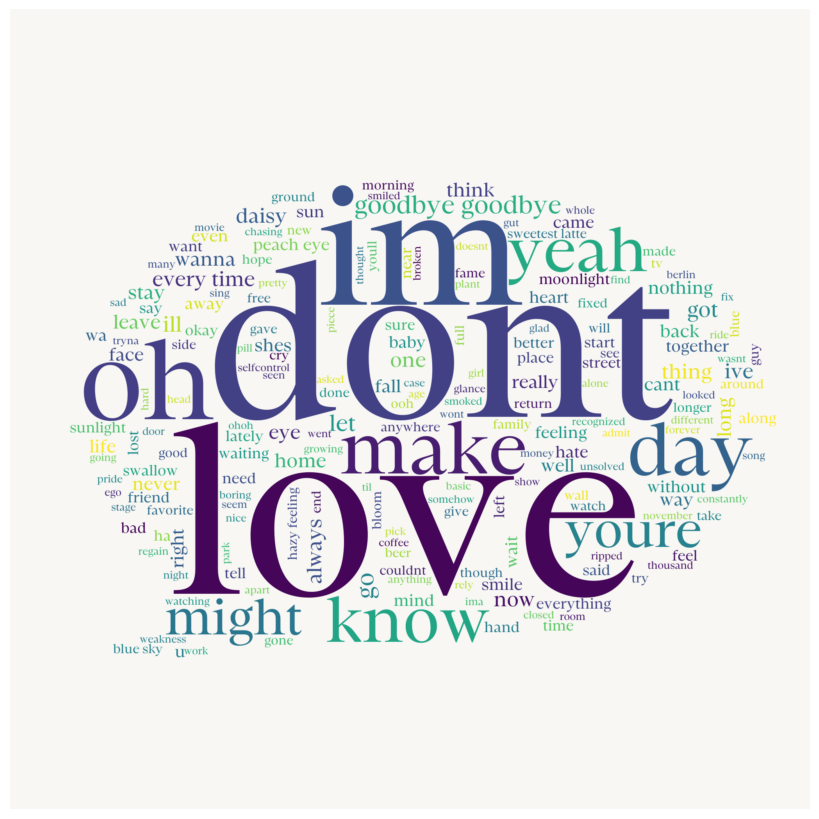

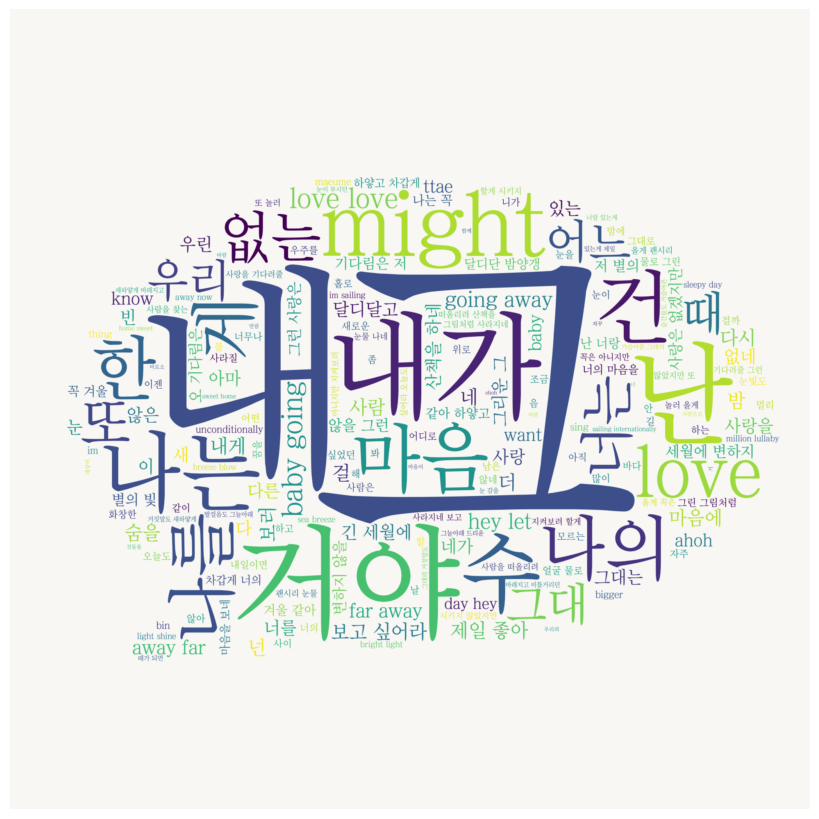

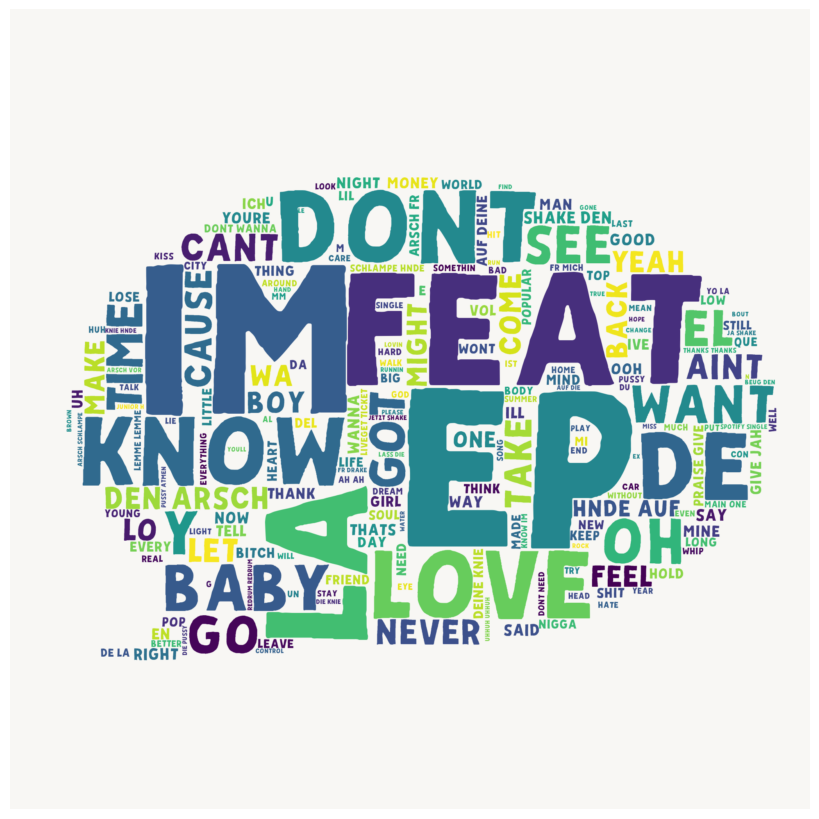

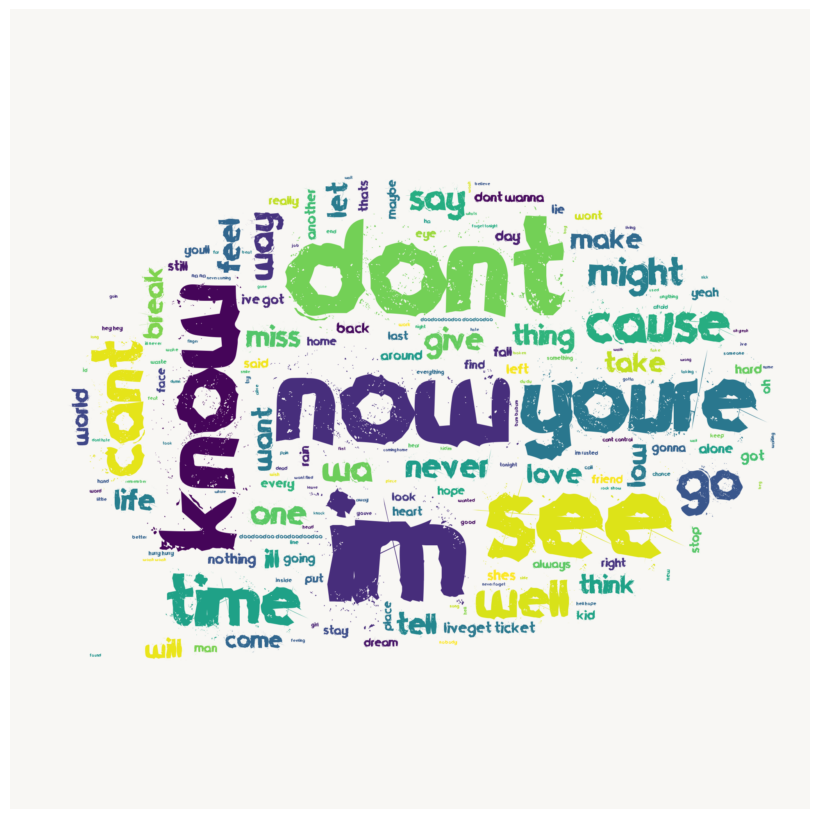

In [39]:
# Generate word clouds for each playlist
for genre in genre_labels:
    generate_wordcloud(genre)

In [29]:
from nltk import word_tokenize
from gensim.models import Word2Vec
import numpy as np
from konlpy.tag import Okt

# Concatenate songs, keeping lines separated
sentences_final = []
for song in np.array(playlist_df['Word2Vec Sentences']):
    for line in song:
        sentences_final.append(line)

# Tokenize words in each line
sentences_final = [word_tokenize(line) for line in sentences_final]

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

def tokenize_korean(text):
    pattern = re.compile(r'[ㄱ-ㅎㅏ-ㅣ가-힣]+')
    return pattern.findall(text)

window_sizes = [4, 5, 6, 7, 8]
results = []

for window in window_sizes:
    model = Word2Vec(sentences=sentences_final, min_count=3, sg=1, hs=1, window=window, vector_size=300)
    word_vectors = model.wv

    # Indie (Eng) playlist
    corpus_indie_eng = ' '.join(playlist_df[playlist_df['Genre'] == 'Indie (Eng)']['Word2Vec Sentences'].sum())
    corpus_indie_eng_list = corpus_indie_eng.split()
    centroid_indie_eng = np.average([word_vectors[w] for w in corpus_indie_eng_list if w in model.wv.key_to_index], axis=0)
    similar_indie_eng = word_vectors.similar_by_vector(centroid_indie_eng)

    # Indie (Kor) playlist
    corpus_indie_kor = ' '.join(playlist_df[playlist_df['Genre'] == 'Indie (Kor)']['Word2Vec Sentences'].sum())
    corpus_indie_kor_list = tokenize_korean(corpus_indie_kor)
    centroid_indie_kor = np.average([word_vectors[w] for w in corpus_indie_kor_list if w in model.wv.key_to_index], axis=0)
    similar_indie_kor = word_vectors.similar_by_vector(centroid_indie_kor)

    # POP (Top50) playlist
    corpus_pop_top50 = ' '.join(playlist_df[playlist_df['Genre'] == 'POP (Top50)']['Word2Vec Sentences'].sum())
    corpus_pop_top50_list = corpus_pop_top50.split()
    centroid_pop_top50 = np.average([word_vectors[w] for w in corpus_pop_top50_list if w in model.wv.key_to_index], axis=0)
    similar_pop_top50 = word_vectors.similar_by_vector(centroid_pop_top50)

    # Punk playlist
    corpus_punk = ' '.join(playlist_df[playlist_df['Genre'] == 'Punk']['Word2Vec Sentences'].sum())
    corpus_punk_list = corpus_punk.split()
    centroid_punk = np.average([word_vectors[w] for w in corpus_punk_list if w in model.wv.key_to_index], axis=0)
    similar_punk = word_vectors.similar_by_vector(centroid_punk)

    results.append({
        'Window Size': window,
        'Indie (Eng)': [f"{word}: {sim:.3f}" for word, sim in similar_indie_eng],
        'Indie (Kor)': [f"{word}: {sim:.3f}" for word, sim in similar_indie_kor],
        'POP (Top50)': [f"{word}: {sim:.3f}" for word, sim in similar_pop_top50],
        'Punk': [f"{word}: {sim:.3f}" for word, sim in similar_punk]
    })

# Display the results as a DataFrame
result_df = pd.DataFrame(results)
print("Results for each window size:")
result_df

Results for each window size:


,Window Size,Indie (Eng),Indie (Kor),POP (Top50),Punk
0,4,"[always: 0.989, problem: 0.988, really: 0.988,...","[네: 0.994, 사랑: 0.988, 걸: 0.987, historia: 0.98...","[lot: 0.995, til: 0.994, without: 0.991, real:...","[always: 0.988, problem: 0.988, hoping: 0.988,..."
1,5,"[blame: 0.993, really: 0.991, crazy: 0.988, he...","[네: 0.993, club: 0.988, 걸: 0.987, para: 0.987,...","[laugh: 0.992, sit: 0.991, smoke: 0.991, busin...","[blame: 0.995, really: 0.989, he: 0.988, aroun..."
2,6,"[really: 0.991, fiend: 0.986, he: 0.986, found...","[네: 0.992, para: 0.992, 걸: 0.989, 수: 0.987, 감을...","[game: 0.992, laugh: 0.991, into: 0.989, real:...","[really: 0.990, he: 0.987, fiend: 0.987, found..."
3,7,"[hate: 0.985, them: 0.983, really: 0.981, knew...","[네: 0.991, deluxe: 0.990, 감을: 0.990, kevin: 0....","[game: 0.992, god: 0.990, til: 0.989, hoping: ...","[hate: 0.984, them: 0.982, really: 0.980, alwa..."
4,8,"[them: 0.988, blame: 0.987, tried: 0.985, hurt...","[네: 0.991, siempre: 0.988, club: 0.985, 할: 0.9...","[game: 0.992, smoke: 0.992, seems: 0.991, foun...","[blame: 0.989, them: 0.988, hurt: 0.985, til: ..."


In [31]:
indie_kor_sentences = playlist_df.loc[playlist_df['Genre'] == 'Indie (Kor)', 'Word2Vec Sentences']
indie_kor_sentences

20    [사람 사이 사람, 바람 사이 바람, 각자의 염원이 바래고, 덧칠되어, ooh 발이...
21    [korean, 난 왜 니가 가진 것들을 부러워하는 걸까, 감당하지도 못할 것들을 ...
22    [한적한 밤 산책하다 보면, 어김없이 생각나는 얼굴, 반짝이는 별을 모아 그리는 그...
23    [우린 오래전부터 어쩔 수 없는 거였어, 우주 속을 홀로 떠돌며 많이 외로워하다가,...
24    [고가도로에 삐져나온 초록잎, 아마 이 도시에서 유일히, 적응 못한 낭만일 거야, ...
25    [hangul, 줄이 그새 줄어들었네, 나를 기다린 줄 알았던, 사람들은 떠나가고 ...
26    [baby 알고 있나요, 아직도 내가 그댈 맴도는 이유, baby 너는 나를 당기는...
27    [정작 필요했던 말들은, 다 덮어 두고서, 어제 오늘 그리고 내일도 별로, 다를 것...
28    [내일이면 나를 버릴 사람들, 걱정하는게 아니에요, 내일이면 난 다시 바다 건너에,...
29    [dont be afraid, 그건 너에게, 무던히 손 내밀던, 나의 모습과, 경계...
30    [hangul, 발걸음을 세며, 비좁고 울먹인 벽들을 지나, 핸들을 잡으면 멍울진 ...
31    [나는 읽기 쉬운 마음이야, 당신도 스윽 훑고 가셔요, 달랠 길 없는 외로운 마음 ...
32    [그땐 난 어떤, 마음이었길래, 내 모든걸 주고도, 웃을 수 있었나, 그대는 또 어...
33    [몇 달은 품던 그 말로, 멋진 옷을 지어 입곤, 텅 빈 방에 누워, 또 잠이나 잤...
34    [내가 손을 잡을게 너는 힘을 빼도 돼, 그저 복사꽃 핀 거릴 걷자, 너의 마음이 ...
35    [떠나는 길에 니가 내게 말했지, 너는 바라는 게 너무나 많아, 잠깐이라도 널 안 ...
36    [난 너랑 있는 게 제일 좋아, 난 너랑 있는 게 제일 좋아, 보고 플 땐 금방 건...
37    [눈을 뜬 오늘도 눈 감을 일 없네, 이 밤에 공기는 새로울 일 없네, 아무

In [32]:
# 최적의 window 크기 선택
best_window = None
max_score = 0

for window in window_sizes:
    score = 0
    for genre in ['Indie (Eng)', 'Indie (Kor)', 'POP (Top50)', 'Punk']:
        words = result_df[result_df['Window Size'] == window][genre].values[0]
        score += len(set(words))
    if score > max_score:
        max_score = score
        best_window = window

print(f"Optimal window size: {best_window}")

Optimal window size: 4


In [33]:
# genre color
genre_colors = {
    'Indie (Eng)': 'blue',
    'Indie (Kor)': 'green',
    'POP (Top50)': 'red',
    'Punk': 'purple'
}

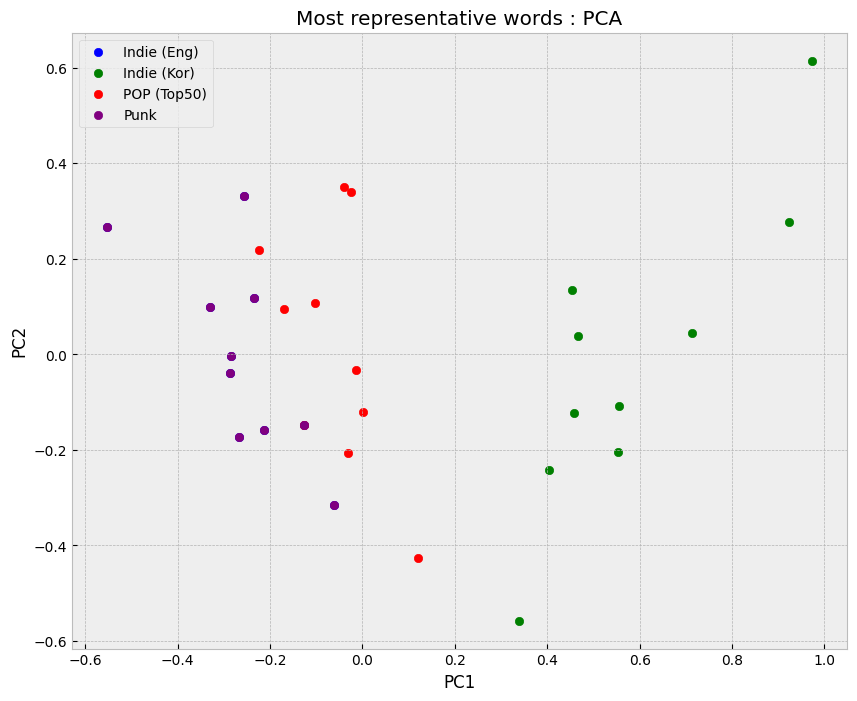

In [34]:
window_size = 4
model = Word2Vec(sentences=sentences_final, min_count=3, sg=1, hs=1, window=window_size, vector_size=300)
word_vectors = model.wv

# Extract word vectors from the word2vec model
centroid_words_indie_eng = [word for word, sim in word_vectors.similar_by_vector(centroid_indie_eng)]

try:
    centroid_words_indie_kor = [word for word, sim in word_vectors.similar_by_vector(centroid_indie_kor)]
except IndexError:
    centroid_words_indie_kor = []

centroid_words_pop_top50 = [word for word, sim in word_vectors.similar_by_vector(centroid_pop_top50)]
centroid_words_punk = [word for word, sim in word_vectors.similar_by_vector(centroid_punk)]

# Plot PCA on most representative words
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.decomposition import PCA

reps_ = centroid_words_indie_eng + centroid_words_indie_kor + centroid_words_pop_top50 + centroid_words_punk
labels = ['Indie (Eng)'] * len(centroid_words_indie_eng) + ['Indie (Kor)'] * len(centroid_words_indie_kor) + ['POP (Top50)'] * len(centroid_words_pop_top50) + ['Punk'] * len(centroid_words_punk)

reps_vec = [word_vectors[w] for w in reps_ if w in word_vectors.key_to_index]
labels = labels[:len(reps_vec)]

# Calculate PCA
pca = PCA(n_components=2)
p = pca.fit_transform(reps_vec)

# Plot PCA results
plt.figure(figsize=(10, 8))
for genre in ['Indie (Eng)', 'Indie (Kor)', 'POP (Top50)', 'Punk']:
    genre_indices = [i for i, label in enumerate(labels) if label == genre]
    plt.scatter(p[genre_indices, 0], p[genre_indices, 1], c=genre_colors[genre],label=genre)
plt.title("Most representative words : PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(prop={'size': 10})
plt.show()

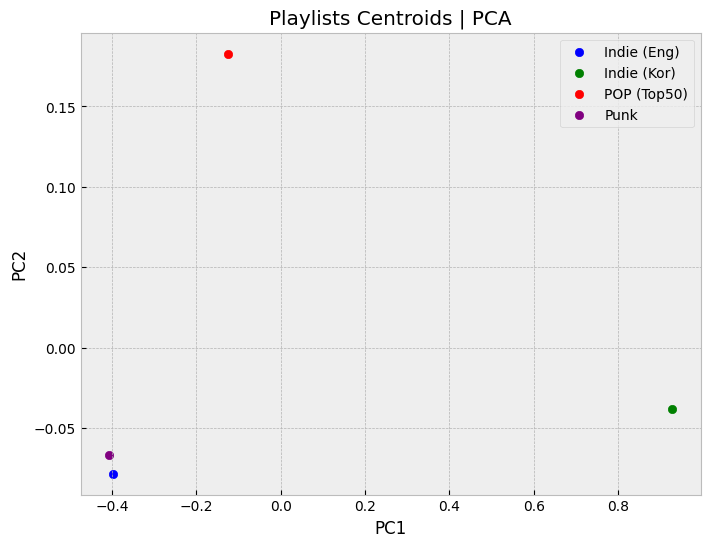

In [35]:
# Plot PCA on centroids only
pca = PCA()
centroids = np.array([centroid_indie_eng, centroid_indie_kor, centroid_pop_top50, centroid_punk])
p = pca.fit_transform(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(p[0, 0], p[0, 1], c='blue', label='Indie (Eng)')
plt.scatter(p[1, 0], p[1, 1], c='green', label='Indie (Kor)')
plt.scatter(p[2, 0], p[2, 1], c='red', label='POP (Top50)')
plt.scatter(p[3, 0], p[3, 1], c='purple', label='Punk')
plt.title("Playlists Centroids | PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(prop={'size': 10})
plt.ticklabel_format(useOffset=False)
plt.show()

In [36]:
window_sizes = [4, 5, 6, 7, 8, 9, 10]
results = []
for window in window_sizes:
    model = Word2Vec(sentences=sentences_final, min_count=3, sg=1, hs=1, window=window, vector_size=300)
    word_vectors = model.wv

    # Indie (Eng) playlist
    corpus_indie_eng = ' '.join(playlist_df[playlist_df['Genre'] == 'Indie (Eng)']['Word2Vec Sentences'].sum())
    corpus_indie_eng_list = corpus_indie_eng.split()
    centroid_indie_eng = np.average([word_vectors[w] for w in corpus_indie_eng_list if w in model.wv.key_to_index], axis=0)
    similar_indie_eng = word_vectors.similar_by_vector(centroid_indie_eng)

    # POP (Top50) playlist
    corpus_pop_top50 = ' '.join(playlist_df[playlist_df['Genre'] == 'POP (Top50)']['Word2Vec Sentences'].sum())
    corpus_pop_top50_list = corpus_pop_top50.split()
    centroid_pop_top50 = np.average([word_vectors[w] for w in corpus_pop_top50_list if w in model.wv.key_to_index], axis=0)
    similar_pop_top50 = word_vectors.similar_by_vector(centroid_pop_top50)

    # Punk playlist
    corpus_punk = ' '.join(playlist_df[playlist_df['Genre'] == 'Punk']['Word2Vec Sentences'].sum())
    corpus_punk_list = corpus_punk.split()
    centroid_punk = np.average([word_vectors[w] for w in corpus_punk_list if w in model.wv.key_to_index], axis=0)
    similar_punk = word_vectors.similar_by_vector(centroid_punk)

    results.append({
        'Window Size': window,
        'Indie (Eng)': [f"{word}: {sim:.3f}" for word, sim in similar_indie_eng],
        'POP (Top50)': [f"{word}: {sim:.3f}" for word, sim in similar_pop_top50],
        'Punk': [f"{word}: {sim:.3f}" for word, sim in similar_punk]
    })

# Display the results as a DataFrame
result_df = pd.DataFrame(results)
print("Results for each window size:")
result_df

Results for each window size:


,Window Size,Indie (Eng),POP (Top50),Punk
0,4,"[really: 0.992, matter: 0.990, enough: 0.989, ...","[blame: 0.993, second: 0.993, til: 0.993, used...","[really: 0.992, maybe: 0.990, enough: 0.989, m..."
1,5,"[understand: 0.990, them: 0.988, nigga: 0.987,...","[game: 0.994, real: 0.992, mouth: 0.991, blame...","[understand: 0.990, hoping: 0.988, them: 0.988..."
2,6,"[really: 0.989, my: 0.987, hate: 0.986, nothin...","[smoke: 0.992, game: 0.991, into: 0.989, hopin...","[really: 0.989, my: 0.987, hate: 0.986, kick: ..."
3,7,"[til: 0.991, blame: 0.987, hate: 0.986, really...","[swear: 0.991, found: 0.990, god: 0.990, game:...","[til: 0.991, blame: 0.988, hate: 0.987, really..."
4,8,"[them: 0.987, til: 0.986, pick: 0.986, resist:...","[worth: 0.992, hoping: 0.991, game: 0.990, mus...","[pick: 0.988, them: 0.987, til: 0.987, resist:..."
5,9,"[them: 0.985, blame: 0.985, til: 0.984, hate: ...","[found: 0.988, worth: 0.987, smoke: 0.986, fai...","[them: 0.986, til: 0.985, blame: 0.985, kick: ..."
6,10,"[lot: 0.988, blame: 0.985, found: 0.984, reall...","[must: 0.994, worth: 0.991, second: 0.988, hop...","[lot: 0.987, blame: 0.986, found: 0.984, reall..."


In [37]:
# Display the results as a DataFrame
result_df = pd.DataFrame(results)
print("Results for each window size:")
result_df

# 최적의 window 크기 선택
best_window = None
max_score = 0
for window in window_sizes:
    score = 0
    for genre in ['Indie (Eng)', 'POP (Top50)', 'Punk']:
        words = result_df[result_df['Window Size'] == window][genre].values[0]
        score += len(set(words))
    if score > max_score:
        max_score = score
        best_window = window

print(f"Optimal window size: {best_window}")

Results for each window size:
Optimal window size: 4


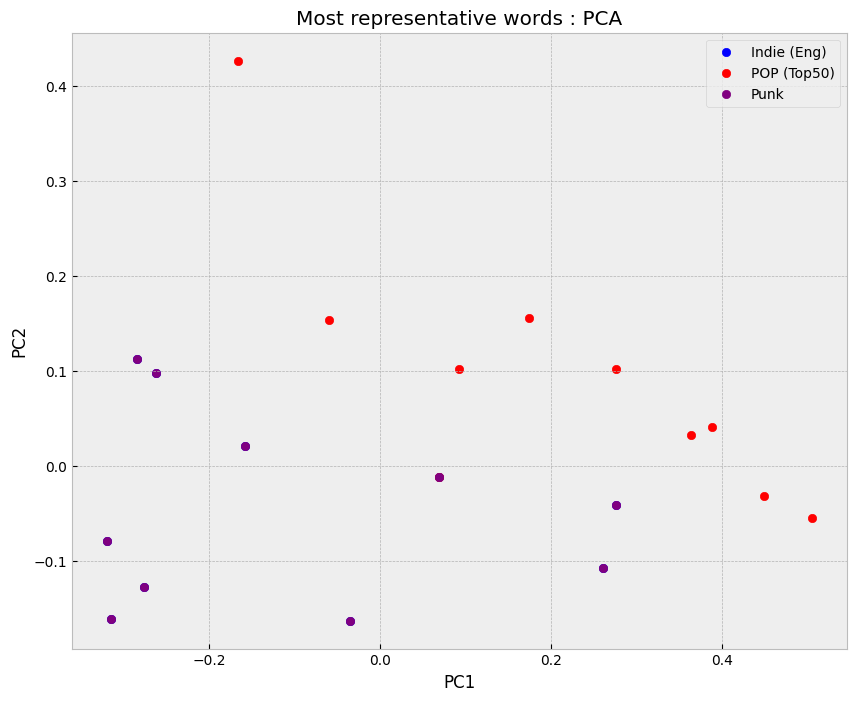

In [38]:
window_size = 4
model = Word2Vec(sentences=sentences_final, min_count=3, sg=1, hs=1, window=window_size, vector_size=300)
word_vectors = model.wv

# Extract word vectors from the word2vec model
centroid_words_indie_eng = [word for word, sim in word_vectors.similar_by_vector(centroid_indie_eng)]
centroid_words_pop_top50 = [word for word, sim in word_vectors.similar_by_vector(centroid_pop_top50)]
centroid_words_punk = [word for word, sim in word_vectors.similar_by_vector(centroid_punk)]

# Plot PCA on most representative words
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.decomposition import PCA

reps_ = centroid_words_indie_eng + centroid_words_pop_top50 + centroid_words_punk
labels = ['Indie (Eng)'] * len(centroid_words_indie_eng) + ['POP (Top50)'] * len(centroid_words_pop_top50) + ['Punk'] * len(centroid_words_punk)

reps_vec = [word_vectors[w] for w in reps_ if w in word_vectors.key_to_index]
labels = labels[:len(reps_vec)]

# Calculate PCA
pca = PCA(n_components=2)
p = pca.fit_transform(reps_vec)

# Plot PCA results
plt.figure(figsize=(10, 8))
for genre in ['Indie (Eng)', 'POP (Top50)', 'Punk']:
    genre_indices = [i for i, label in enumerate(labels) if label == genre]
    plt.scatter(p[genre_indices, 0], p[genre_indices, 1], c=genre_colors[genre],label=genre)

plt.title("Most representative words : PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(prop={'size': 10})
plt.show()

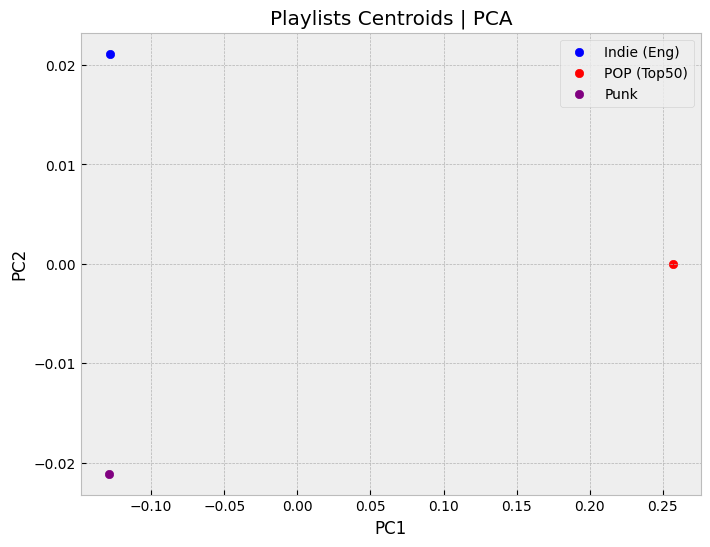

In [39]:
# Plot PCA on centroids only
pca = PCA()
centroids = np.array([centroid_indie_eng, centroid_pop_top50, centroid_punk])
p = pca.fit_transform(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(p[0, 0], p[0, 1], c='blue', label='Indie (Eng)')
plt.scatter(p[1, 0], p[1, 1], c='red', label='POP (Top50)')
plt.scatter(p[2, 0], p[2, 1], c='purple', label='Punk')

plt.title("Playlists Centroids | PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(prop={'size': 10})
plt.ticklabel_format(useOffset=False)
plt.show()

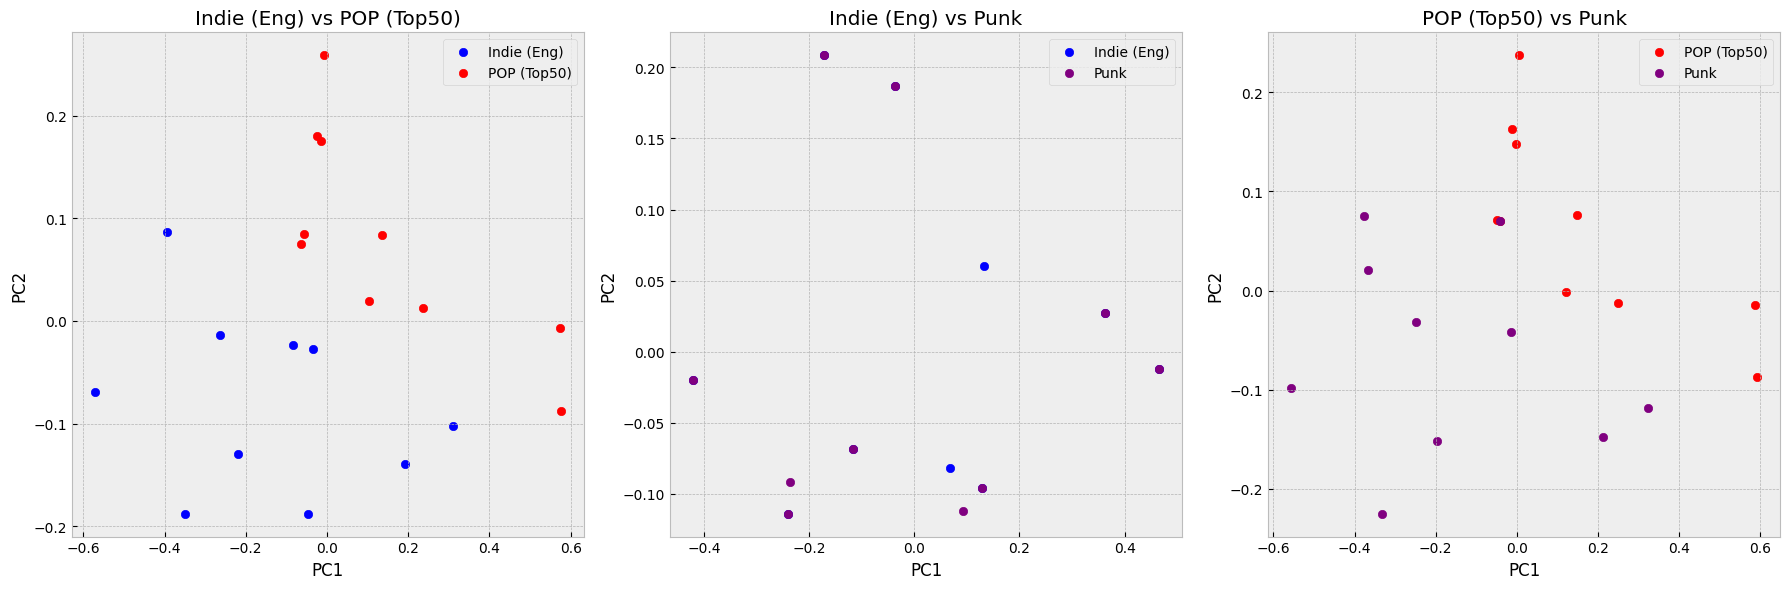

In [40]:
from nltk import word_tokenize
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Concatenate songs, keeping lines separated
sentences_final = []
for song in np.array(playlist_df['Word2Vec Sentences']):
    for line in song:
        sentences_final.append(line)

# Tokenize words in each line
sentences_final = [word_tokenize(line) for line in sentences_final]

# Train Word2Vec model
window_size = 4
model = Word2Vec(sentences=sentences_final, min_count=3, sg=1, hs=1, window=window_size, vector_size=300)
word_vectors = model.wv

# Indie (Eng) playlist
corpus_indie_eng = ' '.join(playlist_df[playlist_df['Genre'] == 'Indie (Eng)']['Word2Vec Sentences'].sum())
corpus_indie_eng_list = corpus_indie_eng.split()
centroid_indie_eng = np.average([word_vectors[w] for w in corpus_indie_eng_list if w in model.wv.key_to_index], axis=0)

# POP (Top50) playlist
corpus_pop_top50 = ' '.join(playlist_df[playlist_df['Genre'] == 'POP (Top50)']['Word2Vec Sentences'].sum())
corpus_pop_top50_list = corpus_pop_top50.split()
centroid_pop_top50 = np.average([word_vectors[w] for w in corpus_pop_top50_list if w in model.wv.key_to_index], axis=0)

# Punk playlist
corpus_punk = ' '.join(playlist_df[playlist_df['Genre'] == 'Punk']['Word2Vec Sentences'].sum())
corpus_punk_list = corpus_punk.split()
centroid_punk = np.average([word_vectors[w] for w in corpus_punk_list if w in model.wv.key_to_index], axis=0)

# Genre combinations
genre_combinations = [
    ('Indie (Eng)', 'POP (Top50)'),
    ('Indie (Eng)', 'Punk'),
    ('POP (Top50)', 'Punk')
]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (genre1, genre2) in enumerate(genre_combinations):
    # Extract word vectors for each genre
    if genre1 == 'Indie (Eng)':
        centroid_words_genre1 = [word for word, sim in word_vectors.similar_by_vector(centroid_indie_eng)]
    elif genre1 == 'POP (Top50)':
        centroid_words_genre1 = [word for word, sim in word_vectors.similar_by_vector(centroid_pop_top50)]
    else:
        centroid_words_genre1 = [word for word, sim in word_vectors.similar_by_vector(centroid_punk)]

    if genre2 == 'Indie (Eng)':
        centroid_words_genre2 = [word for word, sim in word_vectors.similar_by_vector(centroid_indie_eng)]
    elif genre2 == 'POP (Top50)':
        centroid_words_genre2 = [word for word, sim in word_vectors.similar_by_vector(centroid_pop_top50)]
    else:
        centroid_words_genre2 = [word for word, sim in word_vectors.similar_by_vector(centroid_punk)]

    reps_ = centroid_words_genre1 + centroid_words_genre2
    labels = [genre1] * len(centroid_words_genre1) + [genre2] * len(centroid_words_genre2)

    reps_vec = [word_vectors[w] for w in reps_ if w in word_vectors.key_to_index]
    labels = labels[:len(reps_vec)]

    # Calculate PCA
    pca = PCA(n_components=2)
    p = pca.fit_transform(reps_vec)

    # Plot PCA results
    for genre in [genre1, genre2]:
        genre_indices = [i for i, label in enumerate(labels) if label == genre]
        axs[i].scatter(p[genre_indices, 0], p[genre_indices, 1], c=genre_colors[genre],label=genre)

    axs[i].set_title(f"{genre1} vs {genre2}")
    axs[i].set_xlabel("PC1")
    axs[i].set_ylabel("PC2")
    axs[i].legend(prop={'size': 10})

plt.tight_layout()
plt.show()

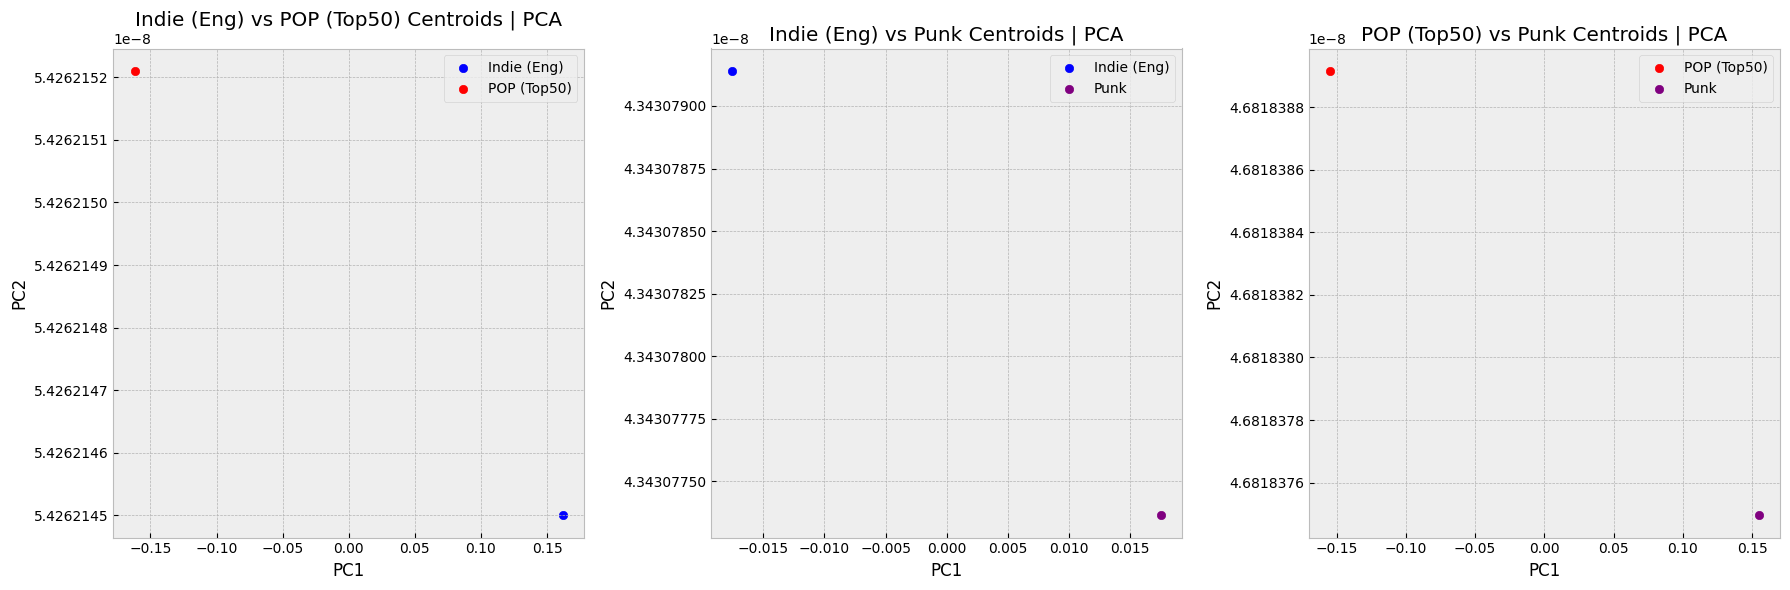

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Create subplots for centroid comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, (genre1, genre2) in enumerate(genre_combinations):
    # Extract centroids for each genre
    if genre1 == 'Indie (Eng)':
        centroid_genre1 = centroid_indie_eng
    elif genre1 == 'POP (Top50)':
        centroid_genre1 = centroid_pop_top50
    else:
        centroid_genre1 = centroid_punk

    if genre2 == 'Indie (Eng)':
        centroid_genre2 = centroid_indie_eng
    elif genre2 == 'POP (Top50)':
        centroid_genre2 = centroid_pop_top50
    else:
        centroid_genre2 = centroid_punk

    # Perform PCA on centroids
    pca = PCA()
    p = pca.fit_transform(np.array([centroid_genre1, centroid_genre2]))
    genre1_coords = p[0]
    genre2_coords = p[1]

    # Plot PCA results
    axs[i].scatter(genre1_coords[0], genre1_coords[1], c=genre_colors[genre1], label=genre1)
    axs[i].scatter(genre2_coords[0], genre2_coords[1], c=genre_colors[genre2], label=genre2)
    axs[i].set_title(f"{genre1} vs {genre2} Centroids | PCA")
    axs[i].set_xlabel("PC1")
    axs[i].set_ylabel("PC2")
    axs[i].legend(prop={'size': 10})
    axs[i].ticklabel_format(useOffset=False)

plt.tight_layout()
plt.show()

In [54]:
# Exclude Indie (Kor) genre from playlist_df
playlist_df_filtered = playlist_df[playlist_df['Genre'] != 'Indie (Kor)']
playlist_df = playlist_df_filtered
playlist_df = playlist_df.dropna(axis=1)

In [55]:
playlist_df

,Genre,Artist,Title,Album,Popularity,Scraped Lyrics,Word2Vec Sentences,Target Label
0,Indie (Eng),The Volunteers,Summer,The Volunteers,43,[verse 1]|our eyes are closed|but we know when...,"[our eye are closed, but we know when the sun ...",0
1,Indie (Eng),The Volunteers,S.A.D,The Volunteers,32,[verse 1]|if i could breathe so easy|like othe...,"[if i could breathe so easy, like others do in...",0
2,Indie (Eng),The Volunteers,New Plant,New Plant,30,[verse 1]|unsolved cases|return to basics|time...,"[unsolved case, return to basic, time to start...",0
3,Indie (Eng),The Volunteers,Nicer,The Volunteers,28,[verse 1]|my boyfriend hates when i smile to t...,[my boyfriend hate when i smile to the other g...,0
4,Indie (Eng),Yerin Baek,Rest,Every letter I sent you.,46,|[verse 1]|waiting for going home feels like a...,[waiting for going home feel like a thousand h...,0
5,Indie (Eng),Yerin Baek,Berlin,Every letter I sent you.,35,|in berlin|what do we do|in november|in this w...,"[in berlin, what do we do, in november, in thi...",0
6,Indie (Eng),Yerin Baek,lovelovelove,Every letter I sent you.,44,|[verse 1]|if i ever have to leave|where would...,"[if i ever have to leave, where would i go, sh...",0
7,Indie (Eng),Yerin Baek,0310,Every letter I sent you.,49,|[verse 1]|you smoked and you looked at me|i h...,"[you smoked and you looked at me, i hate it wh...",0
8,Indie (Eng),wave to earth,bad,0.1 flaws and all.,79,[chorus]|how could my day be bad|when im with ...,"[lately life so boring, ive been watching netf...",0
9,Indie (Eng),wave to earth,peach eyes,0.1 flaws and all.,71,[chorus]|peach eyes and blue skies ill be with...,"[youre mine a soon a i watch your eye, i could...",0


In [85]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
import re
from imblearn.over_sampling import RandomOverSampler

# Spotify API 
client_id = '951abbc874bb4828875735b57dc56cd3'
client_secret = '5dae5c2f08ed43a487c52afb05c5f10b'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
### Test Set Upload

# test id
test_playlists = {
    'Indie (Eng)': '0z2GeSofiV7s5FpdxRGiOB',
    'POP (Top50)': '7fRK05TrIpwvDkiqOP3Ylc',
    'Punk': '5yX2ZoRBexB93WyZA8bz5b'
}

# test dataframe
test_data = []
lyrics_clean1 = []
target_labels = []

# test data from genre
for genre, playlist_id in test_playlists.items():
    results = sp.playlist_tracks(playlist_id)
    
    for item in results['items']:
        track = item['track']
        artist = track['artists'][0]['name']
        title = track['name']
        lyrics = get_lyrics(artist, title) 
        
        
        unwanted_lines = ['chorus', 'bridge', 'intro', 'outro', 'pre-chorus', 'post-chorus', 'interlude', 'guitar solo']
        processed_lines = []
        lemmatizer = WordNetLemmatizer()
        
        # Handle lines containing unwanted content within []
        brackets = re.findall(r'\[[^\]]*\]', lyrics)
        first_occurrence = {word: True for word in unwanted_lines}
        for j, bracket in enumerate(brackets):
            for word in unwanted_lines:
                if word in bracket.lower():
                    if first_occurrence[word]:
                        first_occurrence[word] = False
                    else:
                        start_index = lyrics.find(bracket)
                        end_index = lyrics.find(']', start_index) + 1
                        next_start_index = lyrics.find('[', end_index)
                        if next_start_index == -1:
                            lyrics = lyrics[:start_index]  # Remove from the last [] to the end
                        else:
                            lyrics = lyrics[:start_index] + lyrics[next_start_index:]
        
        lyrics = re.sub(r'\[[^\]]*\]', '', lyrics)
        song_lines = lyrics.split('|')
        
        for line in song_lines:  # Process each line
            if line.strip():  # Skip empty lines
                new_line = []
                all_words = line.split()
                for word in all_words:  # Process each word
                    new_word_1 = re.sub(r'[^a-zA-Z\']', '', word)
                    new_word_2 = new_word_1.lower()
                    new_word_3 = lemmatizer.lemmatize(new_word_2)
                    new_line.append(new_word_3)
                joined_line = " ".join(new_line)  # Needed for Word2Vec sentences
                processed_lines.append(joined_line)
        
        processed_lyrics = ' '.join(processed_lines)
        lyrics_clean1.append(processed_lyrics)
        target_labels.append(genre)
        
        test_data.append({
            'Genre': genre,
            'Artist': artist,
            'Title': title,
            'Lyrics': processed_lyrics
        })

test_df = pd.DataFrame(test_data)
test_df['Target Label'] = target_labels

# Encode target classes
genre_dic = {'Indie (Eng)': 0, 'POP (Top50)': 1, 'Punk': 2}
test_df['Target Label'] = test_df['Target Label'].map(genre_dic)

print(test_df.head(6))

# Add 'Target Label' column to playlist_df
playlist_df['Target Label'] = playlist_df['Genre'].map(genre_dic)

### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
### Prepare train and test sets

# Compute avg vector for each song
def vectorize_songs(songs_list, word2vec_model):
    word_vectors = word2vec_model.wv  # Extract word vectors from the word2vec model
    vectorized_list = []
    for song_lyrics in songs_list:
        song_words = song_lyrics.split()
        song_vectors = [word_vectors[w] for w in song_words if w in word_vectors.key_to_index]
        if song_vectors:
            song_avg_vector = np.mean(song_vectors, axis=0)
            vectorized_list.append(song_avg_vector)
        else:
            vectorized_list.append(np.zeros(word2vec_model.vector_size))
    return np.array(vectorized_list)

# Exclude Indie (Kor) genre from playlist_df
playlist_df_filtered = playlist_df[playlist_df['Genre'] != 'Indie (Kor)']
playlist_df = playlist_df_filtered
playlist_df = playlist_df.dropna(axis=1)

train_df = playlist_df[['Genre', 'Word2Vec Sentences', 'Target Label']]

# divide X and y
X = train_df['Word2Vec Sentences'].apply(lambda x: ' '.join(x)).values.reshape(-1, 1)
y = train_df['Target Label'].values

y_train = np.array(train_df['Target Label'])
X_train_lyrics = np.array(train_df['Word2Vec Sentences'].apply(lambda x: ' '.join(x)))
X_train = vectorize_songs(X_train_lyrics, model)

# test data
y_test = np.array(test_df['Target Label'])
X_test_lyrics = np.array(test_df['Lyrics'])
X_test = vectorize_songs(X_test_lyrics, model)



Searching for "Popo (How deep is our love?)" by Yerin Baek...
Done.
Searching for "Square (2017)" by Yerin Baek...
Done.
Searching for "London" by Yerin Baek...
Done.
Searching for "Lovegame" by Yerin Baek...
Done.
Searching for "seasons" by wave to earth...
Done.
Searching for "light" by wave to earth...
Done.
Searching for "As It Was" by Harry Styles...
Done.
Searching for "Watermelon Sugar" by Harry Styles...
Done.
Searching for "Cold Heart - PNAU Remix" by Elton John...
Done.
Searching for "Don't Start Now" by Dua Lipa...
Done.
Searching for "Peaches (feat. Daniel Caesar & Giveon)" by Justin Bieber...
Done.
Searching for "Die For You" by The Weeknd...
Done.
Searching for "Still Waiting" by Sum 41...
Done.
Searching for "Take My Hand" by Simple Plan...
Done.
Searching for "Sk8er Boi" by Avril Lavigne...
Done.
Searching for "You're Gonna Go Far, Kid" by The Offspring...
Done.
Searching for "Love Drunk" by BOYS LIKE GIRLS...
Done.
Searching for "Still Waiting" by Sum 41...
Done.
     

In [86]:
# Compute avg vector for each song
def vectorize_songs(songs_list, word2vec_model):
    word_vectors = word2vec_model.wv  # Extract word vectors from the word2vec model
    vectorized_list = []
    for song_lyrics in songs_list:
        song_words = song_lyrics.split()
        song_vectors = [word_vectors[w] for w in song_words if w in word_vectors.key_to_index]
        if song_vectors:
            song_avg_vector = np.mean(song_vectors, axis=0)
            vectorized_list.append(song_avg_vector)
        else:
            vectorized_list.append(np.zeros(word2vec_model.vector_size))
    return np.array(vectorized_list)

# Process both playlists
y_train = np.array(train_df['Target Label'])
y_test = np.array(test_df['Target Label'])
X_train_lyrics = np.array(train_df['Word2Vec Sentences'].apply(lambda x: ' '.join(x)))
X_train = vectorize_songs(X_train_lyrics, model)
X_test_lyrics = np.array(test_df['Lyrics'])
X_test = vectorize_songs(X_test_lyrics, model)

print("Number of training samples:", len(train_df))
print("Number of test samples:", len(X_test))

Number of training samples: 120
Number of test samples: 18


In [47]:
test_df

,Genre,Artist,Title,Lyrics,Target Label
0,Indie (Eng),Yerin Baek,Popo (How deep is our love?),get away from your own sorrow let the sun come...,0
1,Indie (Eng),Yerin Baek,Square (2017),all the color and personality you cant see rig...,0
2,Indie (Eng),Yerin Baek,London,it dont make much sense few thing you are look...,0
3,Indie (Eng),Yerin Baek,Lovegame,girl when youre reaching out those hand just l...,0
4,Indie (Eng),wave to earth,seasons,i cant be your love look it too trivial for yo...,0
5,Indie (Eng),wave to earth,light,you always wanted to see the moonlight and i i...,0
6,POP (Top50),Harry Styles,As It Was,come on harry we wanna say goodnight to you ho...,1
7,POP (Top50),Harry Styles,Watermelon Sugar,taste like strawberry on a summer evenin and i...,1
8,POP (Top50),Elton John,Cold Heart - PNAU Remix,oh oh youre my cold heart oh oh it a human sig...,1
9,POP (Top50),Dua Lipa,Don't Start Now,,1


In [87]:
### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
### Logistic Regression Grid Search
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

LR = LogisticRegression(max_iter=1000)
LRCV = GridSearchCV(LR,                       # model
                    param_grid=parameters,   # hyperparameters
                    scoring='accuracy',        # metric for scoring
                    cv=10)                     # number of folds

LRCV.fit(X_train, y_train)
print("Tuned Hyperparameters :", LRCV.best_params_)
print("Accuracy :", LRCV.best_score_)

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.5333333333333334


In [88]:
### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
### Logistic Regression Train & Test
LogReg = LogisticRegression(max_iter=5000, penalty=LRCV.best_params_['penalty'],
                            C=LRCV.best_params_['C'], solver=LRCV.best_params_['solver'])
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)
print(y_pred)  # Prediction

print("Train Accuracy:", LogReg.score(X_train, y_train))
print("Test Accuracy:", LogReg.score(X_test, y_test))

[1 2 2 0 0 2 2 1 1 2 1 1 2 2 2 2 1 2]
Train Accuracy: 0.9833333333333333
Test Accuracy: 0.6111111111111112


In [89]:
from itertools import combinations
# Exclude Indie (Kor) genre from playlist_df
playlist_df_filtered = playlist_df[playlist_df['Genre'] != 'Indie (Kor)']

# Define the genre combinations
genre_combinations = list(combinations(['Indie (Eng)', 'POP (Top50)', 'Punk'], 2))

for genre1, genre2 in genre_combinations:
    print(f"\n--- {genre1} vs {genre2} ---")
    
    # Filter the playlist_df_filtered and test_df for the selected genres
    playlist_df_filtered_subset = train_df[(train_df['Genre'] == genre1) | (train_df['Genre'] == genre2)]
    test_df_subset = test_df[(test_df['Genre'] == genre1) | (test_df['Genre'] == genre2)]
    
    # Process both playlists
    y_train = np.array(playlist_df_filtered_subset['Target Label'])
    y_test = np.array(test_df_subset['Target Label'])
    X_train_lyrics = np.array(playlist_df_filtered_subset['Word2Vec Sentences'].apply(lambda x: ' '.join(x)))
    X_train = vectorize_songs(X_train_lyrics, model)
    X_test_lyrics = np.array(test_df_subset['Lyrics'])
    X_test = vectorize_songs(X_test_lyrics, model)
    
    print("Number of training samples:", len(X_train))
    print("Number of test samples:", len(X_test))
    
    ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
    ### Logistic Regression Grid Search
    parameters = {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.logspace(-3, 3, 7),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    
    LR = LogisticRegression(max_iter=1000)
    LRCV = GridSearchCV(LR,                       # model
                        param_grid=parameters,   # hyperparameters
                        scoring='accuracy',        # metric for scoring
                        cv=10)                     # number of folds
    
    LRCV.fit(X_train, y_train)
    print("Tuned Hyperparameters :", LRCV.best_params_)
    print("Best Accuracy :", LRCV.best_score_)
    
    ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
    ### Logistic Regression Train & Test
    LogReg = LogisticRegression(max_iter=5000, penalty=LRCV.best_params_['penalty'],
                                C=LRCV.best_params_['C'], solver=LRCV.best_params_['solver'])
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    
    # Print the test results
    print("\nTest Results:")
    for i in range(len(test_df_subset)):
        print(f"Title: {test_df_subset.iloc[i]['Title']}, Artist: {test_df_subset.iloc[i]['Artist']}, Actual Genre: {test_df_subset.iloc[i]['Target Label']}, Predicted Genre: {y_pred[i]}")
    
    print("\nTrain Accuracy:", LogReg.score(X_train, y_train))
    print("Test Accuracy:", LogReg.score(X_test, y_test))


--- Indie (Eng) vs POP (Top50) ---
Number of training samples: 70
Number of test samples: 12
Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy : 0.7142857142857143

Test Results:
Title: Popo (How deep is our love?), Artist: Yerin Baek, Actual Genre: 0, Predicted Genre: 1
Title: Square (2017), Artist: Yerin Baek, Actual Genre: 0, Predicted Genre: 1
Title: London, Artist: Yerin Baek, Actual Genre: 0, Predicted Genre: 1
Title: Lovegame, Artist: Yerin Baek, Actual Genre: 0, Predicted Genre: 1
Title: seasons, Artist: wave to earth, Actual Genre: 0, Predicted Genre: 1
Title: light, Artist: wave to earth, Actual Genre: 0, Predicted Genre: 1
Title: As It Was, Artist: Harry Styles, Actual Genre: 1, Predicted Genre: 1
Title: Watermelon Sugar, Artist: Harry Styles, Actual Genre: 1, Predicted Genre: 1
Title: Cold Heart - PNAU Remix, Artist: Elton John, Actual Genre: 1, Predicted Genre: 1
Title: Don't Start Now, Artist: Dua Lipa, Actual Genre: 1, Predicted Genre

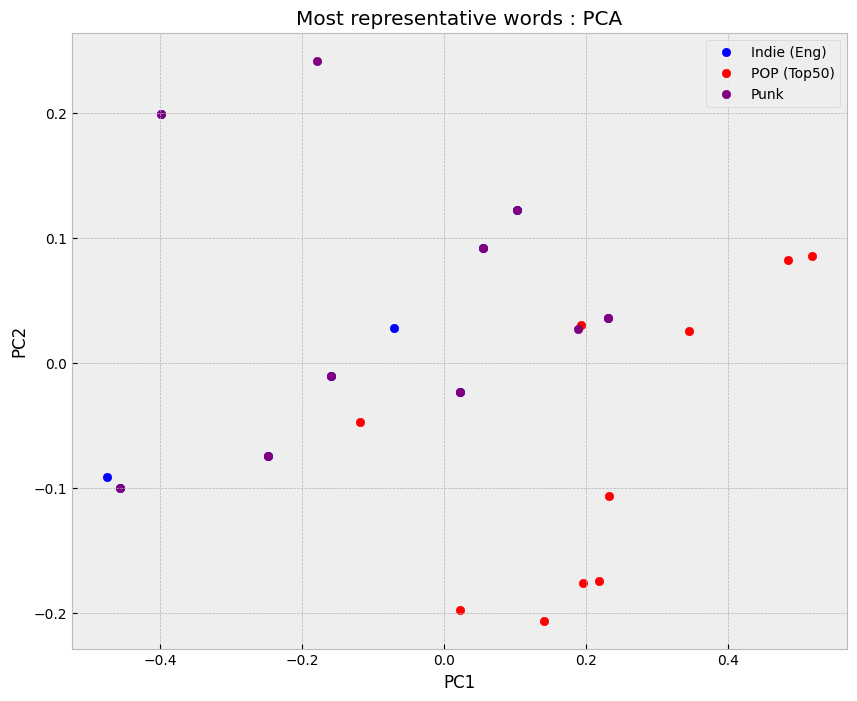

In [90]:
window_size = 7
model = Word2Vec(sentences=sentences_final, min_count=3, sg=1, hs=1, window=window_size, vector_size=300)
word_vectors = model.wv

# use oversampled data
train_df_resampled = pd.DataFrame({
    'Genre': train_df['Genre'].iloc[oversampler.sample_indices_],
    'Word2Vec Sentences': X_resampled.ravel(),
    'Target Label': y_resampled
})

centroids_dict = {}
for genre in ['Indie (Eng)', 'POP (Top50)', 'Punk']:
    genre_data = train_df_resampled[train_df_resampled['Genre'] == genre]['Word2Vec Sentences']
    genre_vectors = [model.wv[word] for sentence in genre_data for word in sentence.split() if word in model.wv]
    centroid = np.mean(genre_vectors, axis=0)
    centroids_dict[genre] = centroid

# Extract word vectors from the word2vec model
centroid_words_indie_eng = [word for word, sim in model.wv.similar_by_vector(centroids_dict['Indie (Eng)'])]
centroid_words_pop_top50 = [word for word, sim in model.wv.similar_by_vector(centroids_dict['POP (Top50)'])]
centroid_words_punk = [word for word, sim in model.wv.similar_by_vector(centroids_dict['Punk'])]

# Plot PCA on most representative words
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn.decomposition import PCA

reps_ = centroid_words_indie_eng + centroid_words_pop_top50 + centroid_words_punk
labels = ['Indie (Eng)'] * len(centroid_words_indie_eng) + ['POP (Top50)'] * len(centroid_words_pop_top50) + ['Punk'] * len(centroid_words_punk)
reps_vec = [model.wv[w] for w in reps_ if w in model.wv]
labels = labels[:len(reps_vec)]

# Calculate PCA
pca = PCA(n_components=2)
p = pca.fit_transform(reps_vec)

# Plot PCA results
plt.figure(figsize=(10, 8))
for genre in ['Indie (Eng)', 'POP (Top50)', 'Punk']:
    genre_indices = [i for i, label in enumerate(labels) if label == genre]
    plt.scatter(p[genre_indices, 0], p[genre_indices, 1], c=genre_colors[genre], label=genre)

plt.title("Most representative words : PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(prop={'size': 10})
plt.show()

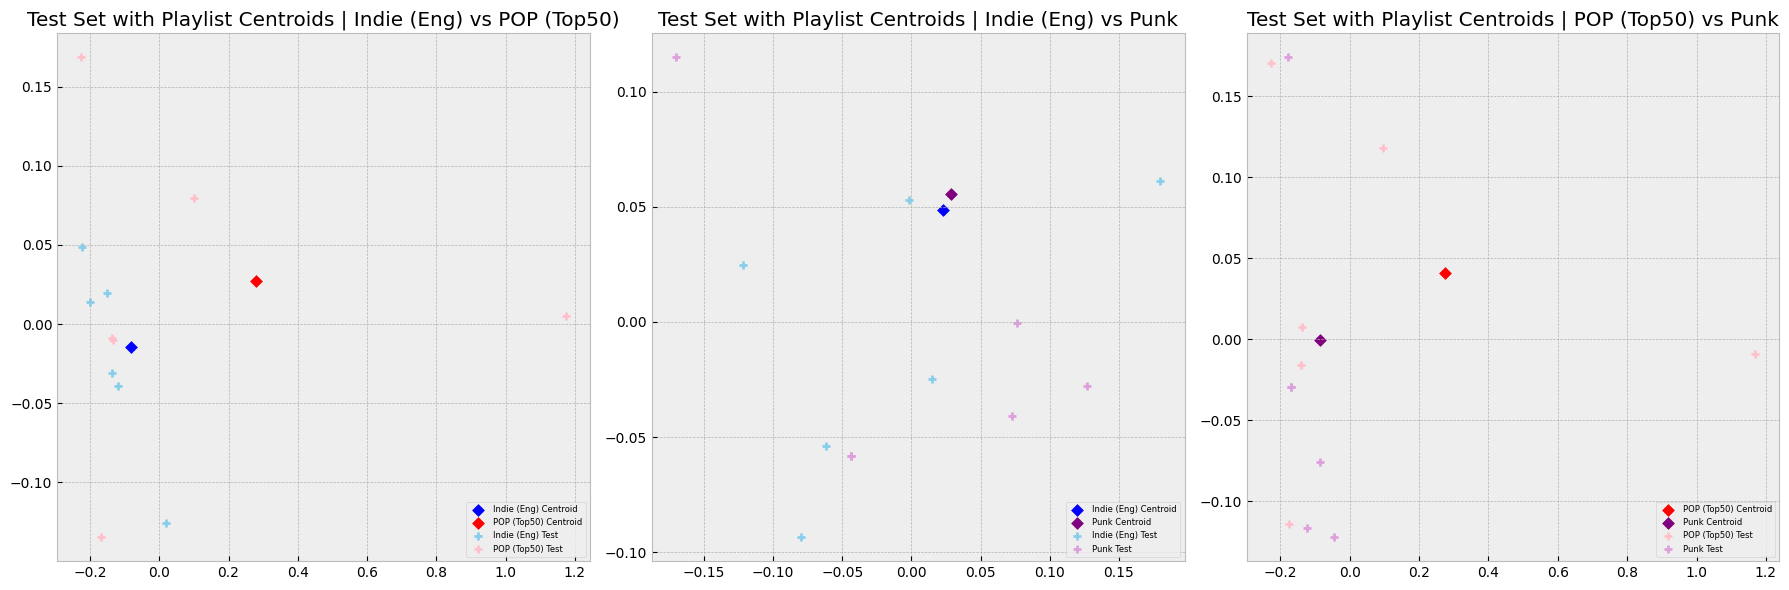

In [91]:
centroids_dict = {}
for genre in ['Indie (Eng)', 'POP (Top50)', 'Punk']:
    genre_data = train_df_resampled[train_df_resampled['Genre'] == genre]['Word2Vec Sentences']
    genre_vectors = [model.wv[word] for sentence in genre_data for word in sentence.split() if word in model.wv]
    centroid = np.mean(genre_vectors, axis=0)
    centroids_dict[genre] = centroid

genre_combinations = [
    ('Indie (Eng)', 'POP (Top50)'),
    ('Indie (Eng)', 'Punk'),
    ('POP (Top50)', 'Punk')
]

test_colors = {
    'Indie (Eng)': 'skyblue',
    'POP (Top50)': 'pink',
    'Punk': 'plum'
}

# plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (genre1, genre2) in enumerate(genre_combinations):
    # choose the centroid
    centroid_1 = centroids_dict[genre1]
    centroid_2 = centroids_dict[genre2]
    
    test_data_1 = test_df[test_df['Genre'] == genre1]
    test_data_2 = test_df[test_df['Genre'] == genre2]
    
    test_sentences_1 = test_data_1['Lyrics'].tolist()
    test_sentences_2 = test_data_2['Lyrics'].tolist()
    
    # caculate the test data's Word2Vec 
    test_vectors_1 = vectorize_songs(test_sentences_1, model)
    test_vectors_2 = vectorize_songs(test_sentences_2, model)
    
    # create plot data
    data_ = [centroid_1, centroid_2]
    data_.extend(test_vectors_1)
    data_.extend(test_vectors_2)
    
    # apply PCA
    pca = PCA()
    p1 = pca.fit_transform(np.array(data_))
    
    cen_1 = p1[0]
    cen_2 = p1[1]
    test_1 = p1[2:2+len(test_vectors_1)]
    test_2 = p1[2+len(test_vectors_1):]
    
    # plot
    axs[i].scatter(cen_1[0], cen_1[1], c=genre_colors[genre1], label=f'{genre1} Centroid', marker='D')
    axs[i].scatter(cen_2[0], cen_2[1], c=genre_colors[genre2], label=f'{genre2} Centroid', marker='D')
    axs[i].scatter(test_1[:,0], test_1[:,1], c=test_colors[genre1], label=f'{genre1} Test', marker='+')
    axs[i].scatter(test_2[:,0], test_2[:,1], c=test_colors[genre2], label=f'{genre2} Test', marker='+')
    
    axs[i].set_title(f"Test Set with Playlist Centroids | {genre1} vs {genre2}")
    axs[i].legend(loc='lower right', prop={'size': 6})

plt.tight_layout()
plt.show()

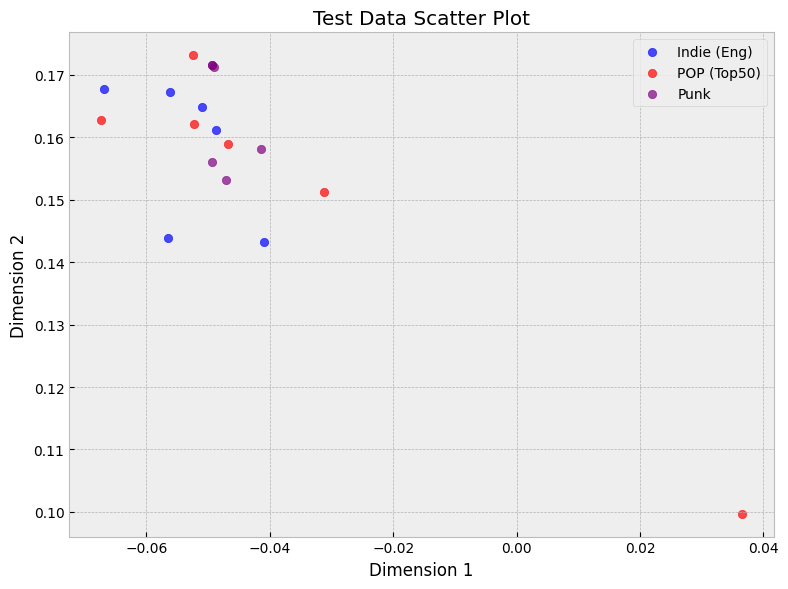

In [92]:

test_vectors = vectorize_songs(test_df['Lyrics'].tolist(), model)

fig, ax = plt.subplots(figsize=(8, 6))

for genre in ['Indie (Eng)', 'POP (Top50)', 'Punk']:
    test_data = test_df[test_df['Genre'] == genre]
    test_indices = test_data.index
    ax.scatter(test_vectors[test_indices, 0], test_vectors[test_indices, 1], c=genre_colors[genre], label=genre, alpha=0.7)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Test Data Scatter Plot')
ax.legend()

plt.tight_layout()
plt.show()